In [999]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import folium 


from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score, ShuffleSplit
from sklearn.model_selection import StratifiedKFold,KFold,GridSearchCV,RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score,mean_squared_error,confusion_matrix
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree



from xgboost import XGBRegressor 
from xgboost import XGBClassifier




In [1000]:
CLIENT_ID = 'GL3FGZDK0NK3FFP4HLAFVLAL4SUEAJHK1SLSIDK550CRKMWH' # your Foursquare ID2
CLIENT_SECRET = '30XHPVWTZJZ20FR0JSUVDYQCQEIAI1WTHSNATW1BJQ1XOSIS' # your Foursquare Secret


VERSION = '20200806'
LIMIT = 90
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GL3FGZDK0NK3FFP4HLAFVLAL4SUEAJHK1SLSIDK550CRKMWH
CLIENT_SECRET:30XHPVWTZJZ20FR0JSUVDYQCQEIAI1WTHSNATW1BJQ1XOSIS


In [1001]:
address = 'New York, NY, United States'


geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


In [1002]:
search_query = 'japanese restaurant'

radius = 40000
print(search_query + ' .... OK!')


pasta .... OK!


In [1003]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    latitude, 
    longitude, 
    VERSION, 
    search_query, 
    radius, 
    LIMIT)


results = requests.get(url).json()
venues = results['response']['venues']  # assign relevant part of JSON to venues


dataframe = pd.json_normalize(venues) # tranform venues into a dataframe


In [1004]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]


venue_id = dataframe_filtered['id']
dataframe_filtered.insert(1, "Team", "Any") 

    

In [1005]:
venue_id = dataframe_filtered['id']

dataframe_filtered = pd.read_csv(r"C:\Users\Anson\Desktop\PythonApplication_anson\1_Anson Test\ss\Anson_Test_Output.csv")# read the orginal document for japanese food`


###Data Cleaning

dataframe_filtered=dataframe_filtered.drop(columns=['Team','crossStreet','labeledLatLngs','postalCode','cc','state','country','formattedAddress','neighborhood'])
dataframe_filtered['categories'] = dataframe_filtered['categories'].replace('food','japanese restaurant')


dataframe_filtered['rating'].replace('', np.nan, inplace=True)
dataframe_filtered.dropna(subset=['rating'], inplace=True)


dataframe_filtered.to_csv (r'C:\Users\Anson\Desktop\PythonApplication_anson\1_Anson Test\Anson_Test_Output.csv', index = False, header=True)





In [1006]:
dataframe_filtered.name

venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Conrad Hotel
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Conrad Hotel',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5, 
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map

venues_map

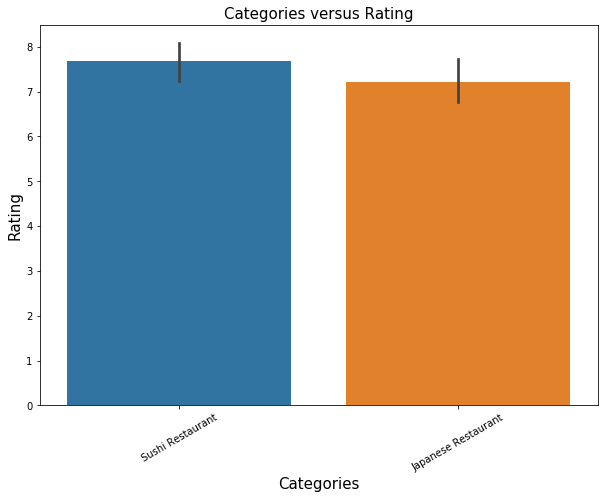

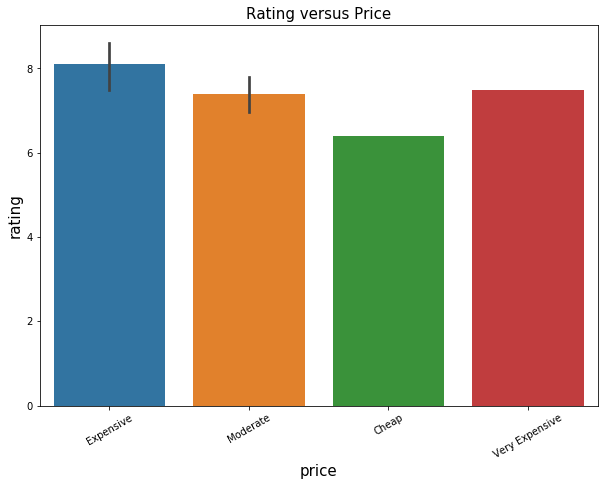

In [1007]:
categories_rating = dataframe_filtered[['categories','rating']]
price_rating = dataframe_filtered[['price','rating']]



fig = plt.figure(figsize=(10,7))
s=sns.barplot(x="categories", y="rating", data=categories_rating)

s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('Categories versus Rating', fontsize=15)
plt.xlabel("Categories", fontsize=15)
plt.ylabel ("Rating", fontsize=15)
plt.show()


fig = plt.figure(figsize=(10,7))
s=sns.barplot(x="price", y="rating", data=price_rating)

s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('Rating versus Price', fontsize=15)
plt.xlabel("price", fontsize=15)
plt.ylabel ("rating", fontsize=15)
plt.show()




In [1008]:
LE = preprocessing.LabelEncoder()
dataframe_filtered['categories'] = LE.fit_transform(dataframe_filtered['categories'])
dataframe_filtered['city'] = LE.fit_transform(dataframe_filtered['city'])
dataframe_filtered['price'] = LE.fit_transform(dataframe_filtered['price'])



Text(0.5, 1.0, 'Elbow Curve')

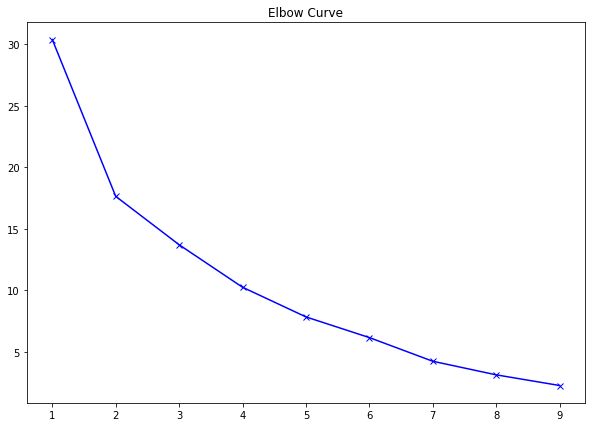

In [1009]:
# K mean
X = dataframe_filtered[['categories','rating','price']]
#X = dataframe_filtered[['categories','rating','price']]

distortions = []
for k in range(1,10):
    k_means = KMeans(n_clusters = k)
    k_means.fit(X)
    distortions.append(k_means.inertia_)
   
    
fig = plt.figure(figsize=(10,7))
plt.plot(range(1,10), distortions, 'bx-')
plt.title("Elbow Curve")

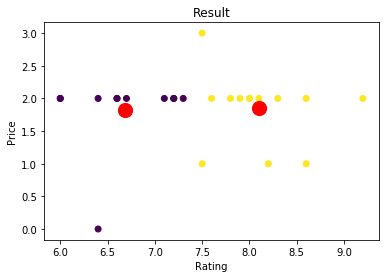

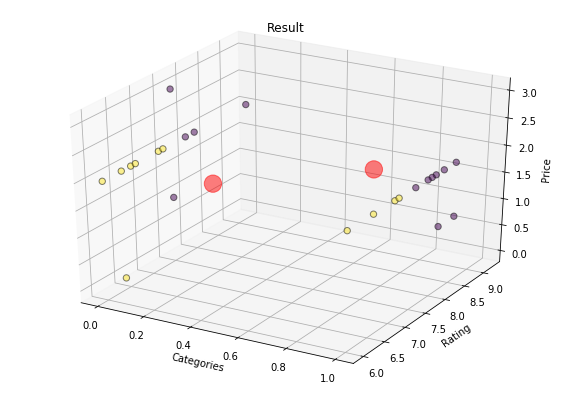

In [1017]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter= 500, n_init= 10)
kmeans.fit(dataframe_filtered[['rating','price']])
plt.scatter(dataframe_filtered['rating'], dataframe_filtered['price'], c=kmeans.labels_, marker="o", picker=True)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color='red', s=200)


plt.title('Result')
plt.xlabel('Rating')
plt.ylabel('Price')
plt.show()



kmeans_3cluster = KMeans(n_clusters=2, init='k-means++', max_iter= 500, n_init= 10)
kmeans_3cluster.fit(dataframe_filtered[['categories','rating','price']])


fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(dataframe_filtered['categories'],dataframe_filtered['rating'],
           dataframe_filtered['price'], 
           c=y_kmeans, cmap='viridis',edgecolor='k', s=40, alpha = 0.5)


ax.set_title("Result")
ax.set_xlabel("Categories")
ax.set_ylabel("Rating")
ax.set_zlabel("Price")
ax.dist = 10

centers = kmeans_3cluster.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', s=300, alpha=0.5, label = 'Centroid');


plt.autoscale(enable=True, axis='x', tight=True)    
plt.show()



In [1011]:
shuffled_database = dataframe_filtered


features = ['categories','city','distance','rating']
shuffled_database[features]=shuffled_database[features].astype(float)

y = shuffled_database['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=10)


In [1012]:
RF_Regression= RandomForestClassifier(random_state=20)
RF_Regression.fit(X_train,y_train)
y_RF_pred=RF_Regression.predict(X_test)
RF_Regression_score=RF_Regression.score(X_test,y_test)

print("with train test split_RandomForestRegression", RF_Regression_score)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_RF_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_RF_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_RF_pred)), '\n')


with train test split_RandomForestRegression 0.8
Mean Absolute Error: 0.3
Mean Squared Error: 0.5
Root Mean Squared Error: 0.7071067811865476 



In [1013]:
XGB_Regression= XGBClassifier()
XGB_Regression.fit(X_train,y_train)
y_XBG_pred=XGB_Regression.predict(X_test)
RF_Regression_score=XGB_Regression.score(X_test,y_test)

print("with train test split_XGBRegression", RF_Regression_score)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_XBG_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_XBG_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_XBG_pred)), '\n')

with train test split_XGBRegression 0.7
Mean Absolute Error: 0.4
Mean Squared Error: 0.6
Root Mean Squared Error: 0.7745966692414834 

